In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# 기계학습 (60점)

### 비트코인 데이터

데이터 경로 : './data/bitcoin_mock.csv'

1분간격의 비트코인 가격에 대한 정보이다. 
- datetime: 1분 단위의 데이터
- open : 시작가
- high : 최고가
- low : 최저가
- close : 종가
- volume : 거래량

In [15]:
df =pd.read_csv('./data/bitcoin_mock.csv')
df.head()

,datetime,open,high,low,close,volume
0,2022-01-01 00:00:00,46216.93,46271.08,46208.37,46250.00,40.57574
1,2022-01-01 00:01:00,46250.00,46344.23,46234.39,46312.76,42.38106
2,2022-01-01 00:02:00,46312.76,46381.69,46292.75,46368.73,51.29955
3,2022-01-01 00:03:00,46368.73,46391.49,46314.26,46331.08,30.45894
4,2022-01-01 00:04:00,46331.07,46336.10,46300.00,46321.34,20.96029


### 기계학습1
모든 데이터 행이 1분간격으로 존재하는지 확인하고 그렇지 않은 경우 누락된 시각의 행을 생성하고 컬럼들의 결측치를 적절히 생성하라.      
결측치가 존재한다면 결측치를 처리하라

In [106]:
df['datetime'] = pd.to_datetime(df['datetime'])
display(df.diff(1)['datetime'].value_counts())
df['diff'] = df['datetime'].diff(1).dt.seconds

# method1 노가다로 추가

lst = []

# df[df['diff'] ==120].index    diff 확인
idx_lst = [0] + list(df[df['diff'] ==120].index)

for i,idx in enumerate(idx_lst[:-1]):
    
    target_df = df.iloc[idx_lst[i]:idx_lst[i+1]]
    
    
# 해당 영역의 전체 datetime 값을 만들고 머지
date_ranges = pd.DataFrame(pd.date_range(start = '2022-01-01 00:00:00',end = '2023-03-02 19:12:00',freq='1T'),columns =['datetime'])
t = pd.merge(date_ranges,df,how='outer').drop(columns =['diff'])
t.iloc[:,1:] = t.iloc[:,1:].combine_first((t.drop(columns='datetime').fillna(method = 'bfill') + t.drop(columns='datetime').fillna(method = 'ffill'))/2)

0 days 00:01:00    613102
0 days 00:02:00        25
Name: datetime, dtype: int64

### 기계학습2

t(분)까지 데이터가 확정된 시점에서 매도,매수를 판단하기 위한 알고리즘을 만들고 백테스팅을 진행하려한다.       
아래의 과정의 전처리를 시행하고 algorithm과 result 두 범주형 컬럼의 교차테이블을 출력하라

---
알고리즘
1. t(분)시점에서 t(분)시점과 t-1(분)시점의 5분,120분 이동평균값을 't_5', 't_120'으로 컬럼을 만들어 구한다.
---
2. - t의 5분 이동평균값은 120분 이동평균값보다 높고 t-1의 5분 이동평균값은 120분 이동평균값보다 낮은 경우 : 'buy'   # 매수  
   - t의 5분 이동평균값은 120분 이동평균값보다 낮고 t-1의 5분 이동평균값은 120분 이동평균값보다 높은 경우 : 'sell'  # 매도
   - 그외 'stay'    
   
   위의 조건으로 buy(매수), sell(매도)를 판단하고 buy,sell,stay를 나타내는 새로운 컬럼 'algorithm'을 생성한다.
---         
3. t+10(분)의 open 값과 t(분)의 close값을 비교하여 새로운 컬럼 'result'를 만든다.
   - 여부가 'buy' 이고 t+10(분) open >= t(분) close : 'profit'
   - 여부가 'buy' 이고 t+10(분) open <  t(분) close : 'loss'
   - 여부가 'sell' 이고 t+10(분) open >= t(분) close : 'loss'
   - 여부가 'sell' 이고 t+10(분) open <  t(분) close : 'profit'
   - 여부가 'stay' 이면 : 'stay' 
   
   위의 조건으로 컬럼값을 채운다

In [245]:
tt = t.copy()

tt['t_5'] = tt['close'].rolling(5).mean()
tt['t-1_5'] = tt['t_5'].shift(1)

tt['t_120'] = tt['close'].rolling(120).mean()
tt['t-1_120'] = tt['t_120'].shift(1)

tf = tt.dropna().reset_index(drop=True)

def algo(x):
    if x['t_5'] > x['t_120'] and x['t-1_5'] < x['t-1_120']:
        return 'buy'
    
    elif x['t_5'] < x['t_120'] and x['t-1_5'] > x['t-1_120']:
        return 'sell'
    else:
        return 'stay'
    
tf['algorithm'] = tf[['t_5','t-1_5','t_120','t-1_120']].apply(algo,axis=1)    

tf['t+10'] = tf['open'].shift(-10)

def result_filter(x):
    if x['algorithm'] =='stay':        
        return 'stay'
    
    elif x['algorithm'] =='buy':
        if x['close'] <= x['t+10']:
            return'profit'   
        else:
            return 'loss'
        
    elif x['algorithm'] =='sell':
        if x['close'] <= x['t+10']:
            return'loss'
        
        else:
            return 'profit'  
    else:
        return 'error'

tf['result'] = tf.apply(result_filter,axis=1)

pd.crosstab(tf['result'],tf['algorithm'])

algorithm,buy,sell,stay
result,,,
loss,3756,3793,0
profit,3563,3526,0
stay,0,0,598395


### 기계학습3     
위에서 전처리한 데이터에 대해 아래 조건으로 그래프를 출력하라
1. 2022-01-01 08:00:00 ~ 2022-01-01 15:00:00 시간대의 close값의 선형 그래프
2. 위 시간대에 대해 algorithm 컬럼이 buy일 경우 빨간 수직선, sell일 경우 파란 수직선

<img src="./data/1.png" height='300' width='1200' style="float: left; margin-right: 10px;">

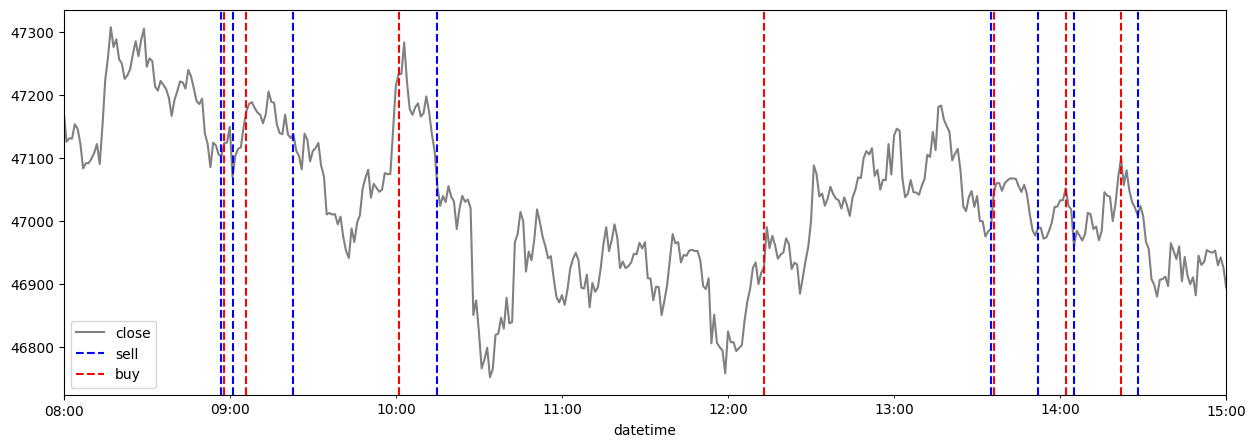

In [259]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,5))

filter_df = tf[(tf.datetime >= pd.to_datetime('2022-01-01 08:00:00')) & (tf.datetime <= pd.to_datetime('2022-01-01 15:00:00'))]
filter_df[['datetime','close']].plot(x='datetime',ax=ax,c='gray')


for data in filter_df[filter_df.algorithm.isin(['sell','buy'])][['datetime','algorithm']].values:
    
    if data[1] =='buy':
        ax.axvline(data[0],color='r',linestyle='--',label='buy')
        
    else:
        ax.axvline(data[0],color='b',linestyle='--',label='sell')
        
ax.legend(ax.get_legend_handles_labels()[0][:3],ax.get_legend_handles_labels()[1][:3])
plt.show()

### 기계학습4
아래의 정의된 컬럼들로 result의 loss와 profit을 예측하는 모델을 만들려고 한다.

- open
- 시작가,종가 가격차이 (open - close)
- algorithm
- t분과 t-5시점의 close값의 차이 (t , t-5)

2022년 2월 ~ 12월까지의 데이터를 train  2023년 1~2월의 데이터를 평가 데이터로 하고 result의 값이 loss,profit인 데이터만 학습에 사용하여     
랜덤포레스트와 서포트 벡터머신 분류모델을 만들고 test데이터에 대해 accuracy를 비교하라. test데이터에 대한 예측 진행시 profit일 확률이 60%이상인 경우에만 profit으로 예측한다

In [330]:
tf['t-5'] = tf['close'].shift(-5)
tf['del_5min'] = tf['close'] - tf['t-5']
tf['del_oc'] = tf['open'] - tf['close']
model_df = tf[tf.result.isin(['profit','loss'])][['datetime','open','algorithm','del_oc','del_5min','result']].reset_index(drop=True)

model_df_dummies = pd.get_dummies(model_df,columns=['algorithm'])
model_df_dummies['month'] = model_df_dummies['datetime'].dt.strftime('%y%m')

train = model_df_dummies[model_df_dummies.month.astype('int').isin(range(2202,2213))].drop(columns =['month','datetime']).reset_index(drop=True)
test = model_df_dummies[model_df_dummies.month.astype('int').isin(range(2301,2303))].drop(columns =['month','datetime']).reset_index(drop=True)


train_x = train.drop(columns = ['result'])
train_y = train['result'].map({'loss':0,'profit':1})

test_x = test.drop(columns =['result'])
test_y = test['result'].map({'loss':0,'profit':1})


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler



rf = RandomForestClassifier(random_state=1)
svc =SVC(probability=True)

sc = StandardScaler()
scaled_train_x = sc.fit_transform(train_x)



In [313]:
%%time
rf.fit(train_x,train_y)
svc.fit(scaled_train_x,train_y)

CPU times: user 21.7 s, sys: 745 ms, total: 22.4 s
Wall time: 22.5 s


SVC(probability=True)

In [320]:
rf_predict_df = pd.DataFrame(rf.predict_proba(test_x))
svc_predcit_df = pd.DataFrame(svc.predict_proba(sc.transform(test_x)))
                             
rf_predict_df['label'] = rf_predict_df[1].map(lambda x : 1 if x >=0.6 else 0)
svc_predcit_df['label'] = svc_predcit_df[1].map(lambda x : 1 if x >=0.6 else 0)

In [329]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_y,rf_predict_df['label']),accuracy_score(test_y,svc_predcit_df['label']))

0.720763723150358 0.7474940334128878


### 유저의 카드사용 데이터

데이터 출처 :https://www.kaggle.com/datasets/arjunbhasin2013/ccdata     
dataurl ='./data/user_data.csv'

다음은 Credit Card 데이터셋의 데이터 사전 및 각 컬럼의 한글 번역입니다:

1. **CUST_ID**: 신용카드 보유자 식별

2. **BALANCE**: 계좌에 남아 있는 구매 가능 잔액

3. **BALANCE_FREQUENCY**: 잔액 업데이트 빈도, 0과 1 사이의 점수 (1 = 자주 업데이트됨, 0 = 자주 업데이트되지 않음)

4. **PURCHASES**: 계좌에서의 구매 금액

5. **ONEOFF_PURCHASES**: 한 번에 최대 구매 금액

6. **INSTALLMENTS_PURCHASES**: 할부로 구매한 금액

7. **CASH_ADVANCE**: 사용자가 미리 지급한 현금

8. **PURCHASES_FREQUENCY**: 구매 빈도, 0과 1 사이의 점수 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

9. **ONEOFFPURCHASESFREQUENCY**: 일회성 구매 빈도 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

10. **PURCHASESINSTALLMENTSFREQUENCY**: 할부 구매 빈도 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

11. **CASHADVANCEFREQUENCY**: 현금 선지급 빈도 (1 = 자주 선지급함, 0 = 자주 선지급하지 않음)

12. **CASHADVANCETRX**: 현금 선지급으로 이루어진 거래 수

13. **PURCHASES_TRX**: 구매 거래 수

14. **CREDIT_LIMIT**: 사용자 신용카드의 한도

15. **PAYMENTS**: 사용자가 지불한 금액

16. **MINIMUM_PAYMENTS**: 사용자가 지불한 최소 금액

17. **PRCFULLPAYMENT**: 사용자가 지불한 전체 금액의 백분율

18. **TENURE**: 신용카드 서비스 사용 기간

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('./data/user_data.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### 기계학습
데이터 EDA를 실시하고 결측치와 이상치를 처리하라 (시각화 포함)

In [79]:
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())

In [80]:
df.describe().T[['mean','min','50%','max']]

,mean,min,50%,max
BALANCE,1564.474828,0.000000,873.385231,19043.13856
BALANCE_FREQUENCY,0.877271,0.000000,1.000000,1.00000
PURCHASES,1003.204834,0.000000,361.280000,49039.57000
ONEOFF_PURCHASES,592.437371,0.000000,38.000000,40761.25000
INSTALLMENTS_PURCHASES,411.067645,0.000000,89.000000,22500.00000
CASH_ADVANCE,978.871112,0.000000,0.000000,47137.21176
PURCHASES_FREQUENCY,0.490351,0.000000,0.500000,1.00000
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.000000,0.083333,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.000000,0.166667,1.00000
CASH_ADVANCE_FREQUENCY,0.135144,0.000000,0.000000,1.50000


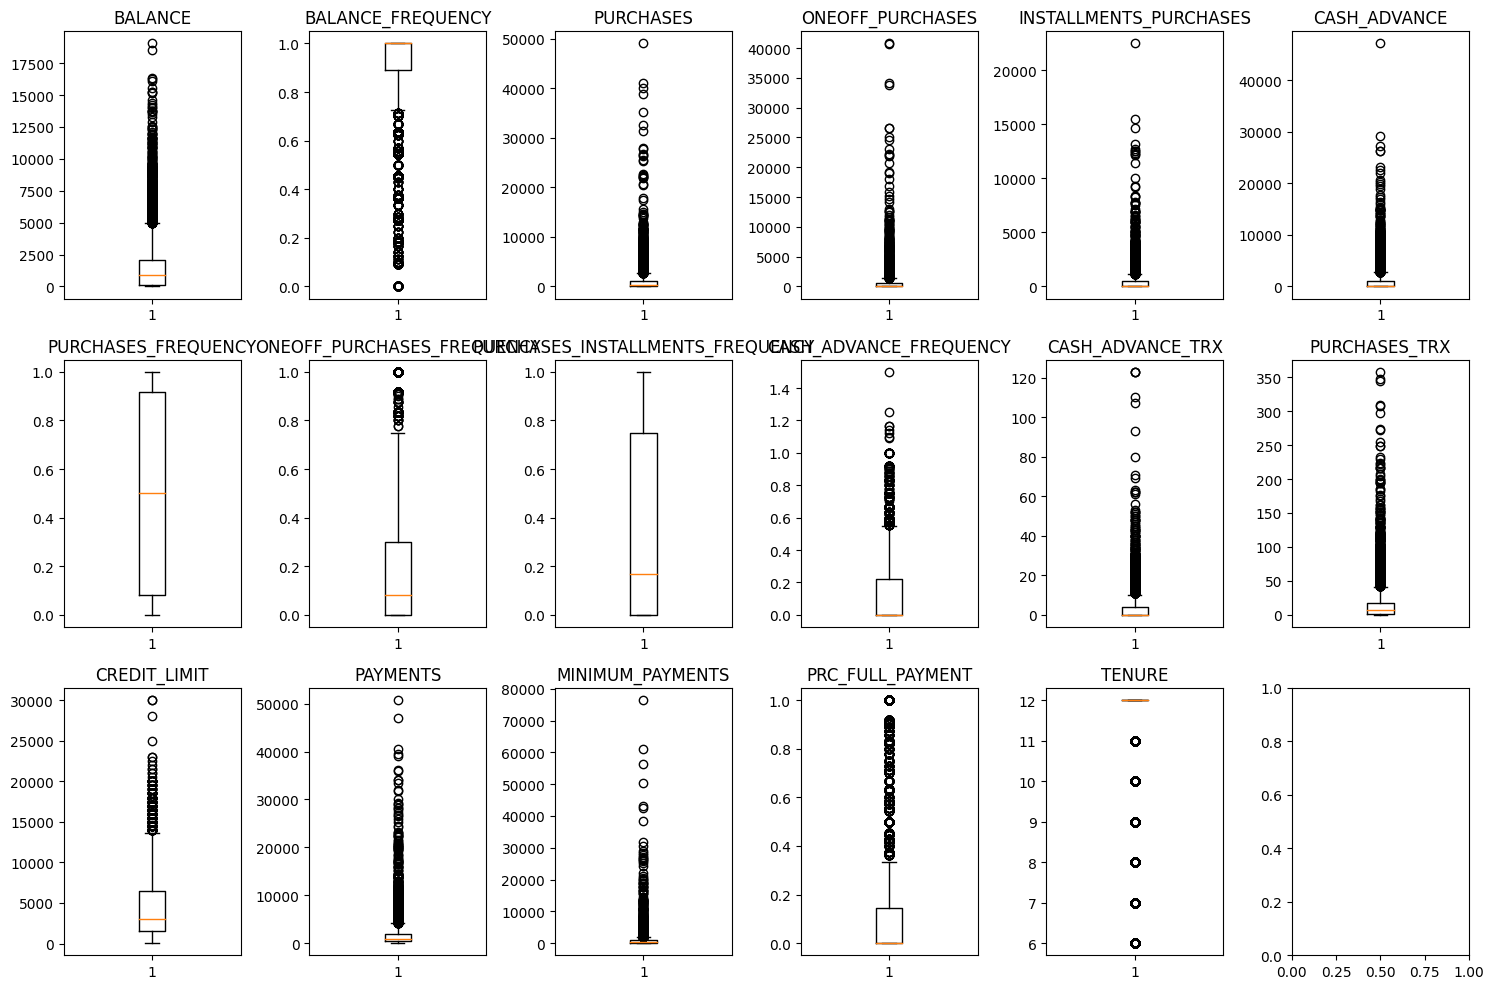

In [81]:
fig,axes = plt.subplots(3,6,figsize=(15,10))

for i,col in enumerate(df.columns[1:]):
    
    axes.flat[i].boxplot(df[col])
    axes.flat[i].set_title(col)
    
fig.tight_layout()


In [82]:
def filter_iqr(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1

    upper = q3 + iqr*1.5
    under = q1 - iqr*1.5

    df_filter = df[(df[col] >=under)& (df[col] <=upper)].reset_index(drop=True)
    print(col,'이상치 제거전', df.shape)
    print(col,'이상치 제거후', df_filter.shape)
    return df_filter

df_filter_df1 = filter_iqr(df,'PURCHASES')
df_filter_df2 = filter_iqr(df_filter_df1,'MINIMUM_PAYMENTS')
df_filter_df3 = filter_iqr(df_filter_df2,'PAYMENTS')

PURCHASES 이상치 제거전 (8950, 18)
PURCHASES 이상치 제거후 (8142, 18)
MINIMUM_PAYMENTS 이상치 제거전 (8142, 18)
MINIMUM_PAYMENTS 이상치 제거후 (7504, 18)
PAYMENTS 이상치 제거전 (7504, 18)
PAYMENTS 이상치 제거후 (6886, 18)


### 기계학습6     
PCA를 통해 적절한 차원으로 데이터를 축소하고 평가하라

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_filter_df3.drop(columns =['CUST_ID'])
sc = StandardScaler()
pca =PCA()

scaled_df = sc.fit_transform(X)
pca.fit(scaled_df)

ep = pd.DataFrame(pca.explained_variance_ratio_,columns =['ratio'])
ep['cumsum'] = ep['ratio'].cumsum()
ep

pca =PCA(n_components=8)
target_pca_df = pca.fit_transform(scaled_df)

### 기계학습7     
위의 차원 축소된 데이터를 바탕으로 KMeans 클러스터링을 실시하라.     
응집도와 분리도를 기반으로 적절 클러스터 숫자를 구하고 두개의 주성분 차원에 군집 중심을 포함하여 시각화하라

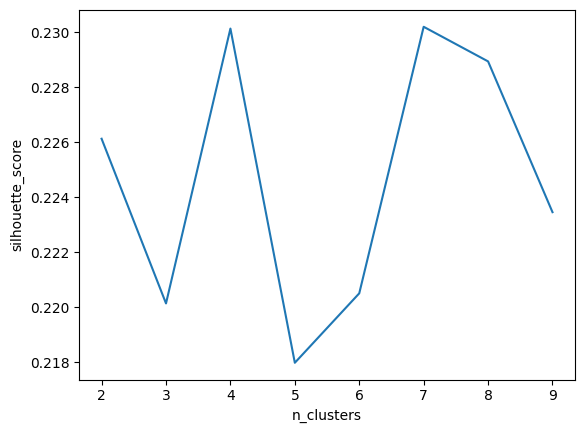

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

lst = []
for n_clusters in range(2,10):
    km = KMeans(n_clusters=n_clusters,n_init= 10,random_state=1)
    km.fit(target_pca_df)
    
    km_predict = km.predict(target_pca_df)
    
    ss = silhouette_score(target_pca_df,km_predict)
    lst.append(ss)
    
    
plt.plot(range(2,10),lst)
plt.xlabel('n_clusters')
plt.ylabel('silhouette_score')
plt.show()

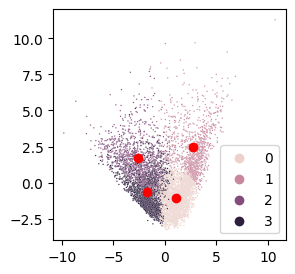

In [85]:
import seaborn as sns
km = KMeans(n_clusters=4,n_init= 10,random_state=1)
km.fit(target_pca_df)
km_predict = km.predict(target_pca_df)


fig,ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x = target_pca_df[:,0],y = target_pca_df[:,1],s=1,hue = km_predict,ax=ax)

ax.scatter(km.cluster_centers_[0][0],km.cluster_centers_[0][1],label='center',c='r')
ax.scatter(km.cluster_centers_[1][0],km.cluster_centers_[1][1],label='center',c='r')
ax.scatter(km.cluster_centers_[2][0],km.cluster_centers_[2][1],label='center',c='r')
ax.scatter(km.cluster_centers_[3][0],km.cluster_centers_[3][1],label='center',c='r')
plt.show()

### 기계학습8   
마케팅 담당자인 당신은 KMeans 군집 결과를 통해 각 군집 특성을 파악하고 군집별 프로모션 전략을 서술하라
    

In [89]:
df_filter_df3['label'] = km_predict
df_filter_df3.drop(columns =['CUST_ID']).groupby(['label']).mean().T.loc[['BALANCE','PURCHASES','PURCHASES_FREQUENCY'],:]

label,0,1,2,3
BALANCE,746.470523,3111.035626,1144.039718,433.596086
PURCHASES,181.321778,216.854774,1485.047970,668.753923
PURCHASES_FREQUENCY,0.168455,0.196491,0.803087,0.865992


BALANCE: 계좌에 남아 있는 구매 가능 잔액
PURCHASES: 계좌에서의 구매 금액
PURCHASES_FREQUENCY: 구매 빈도, 0과 1 사이의 점수 (1 = 자주 구매함, 0 = 자주 구매하지 않음)
위의 세가지 컬럼에만 주목해서 군집별 특성을 살펴보면

0번 군집은 계좌잔액은 적은편이고 구매금액과 구매빈도가 낮은 편이다. 생활 실속형 구매집단이다.     
1번 군집은 계좌잔액은 가장 많지만 구매빈도와 구매금액이 낮은 편이다. 계좌에 잔고가 많은 구매 가능성이 높은 집단이다.           
2번 군집은 계좌잔액은 조금 많이만 구매금액과 구매금액이 큰 편이다. 고가의 금액을 자주 구매하는 구메집단이다.   
4번 군집은 계좌잔액은 가장 낮고 구매금액과 빈도는 큰편이다. 낮은 금액의 상품은 빈도높게 구매하는 구매집단이다.        

이와 같은 군집 특성 분석을 통해 프로모션을 진행한다고 하면 0번,1번,3번 집단에게는 생활용품 할인 쿠폰등의 안내를
2번 군집에는 자주 구매하는 제품들의 할인 쿠폰 혹은 신상 제품등을 전략적으로 프로모션한다.    

### 기계학습9
병합적 계층군집을 실시하고 덴드로그램을 시각화하라. 군집간 거리는 ward 방식으로 업데이트하며 위 문제에서 구한 최적 군집이 만들어지 지기 위한 거리 범위를 구하라

In [415]:
from scipy.cluster.hierarchy import dendrogram,linkage

lk = linkage(target_pca_df,'ward')

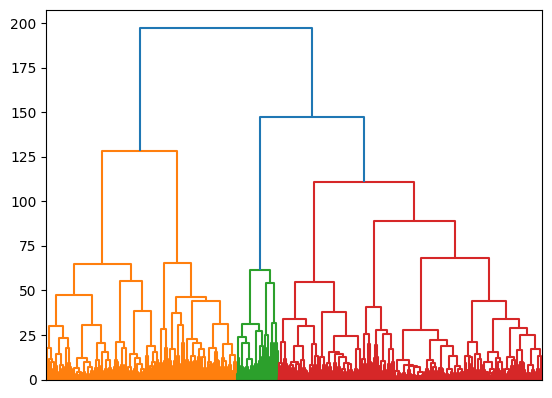

In [418]:
d = dendrogram(lk)
plt.xticks([])
plt.show()

첫 번째 값 (dcoord[i][0]): 선분의 시작 지점의 y좌표.     
두 번째 값 (dcoord[i][1]): 선분의 중간 지점의 y좌표 (시작 지점에서 수평으로 이동한 지점).    
세 번째 값 (dcoord[i][2]): 선분의 중간 지점의 y좌표 (중간에서 수평으로 이동한 지점).   
네 번째 값 (dcoord[i][3]): 선분의 끝 지점의 y좌표.    

In [439]:
import numpy as np

In [440]:
r = pd.DataFrame(np.array(d['dcoord']))

In [441]:
r[r[2] >110]

,0,1,2,3
2654,65.100560,128.127845,128.127845,65.333054
6882,54.503734,110.670735,110.670735,89.048865
6883,61.678444,147.338514,147.338514,110.670735
6884,128.127845,197.572529,197.572529,147.338514


3번째 컬럼들이 threshold값의 y좌료이다 4개의 군집으로 나누기 위해서는 110.67보다 크고 128.127보다 작으면 된다

# 통계 (40점)

### 통계1      
어느 자동차 회사의 본사에서 여러 지방 영업소에 내려보낸 43대의 새 차 중 11대에 불량 오디오가 설치되었다고 한다. 어느 영업소가 8대를 인수하였는데 이 중에서 오디오가 불량인 차가 적어도 2대 이상이 될 확률을 구하라.

In [336]:
from scipy.stats import hypergeom


rv= hypergeom(43,11,8)
1 - rv.pmf(0) - rv.pmf(1)

0.6721384488647233

### 통계2
data_path = ./data/stats_reg1.csv     
종속변수 : Target   
독립변수 : 다양한 센서데이터

In [1]:
import pandas as pd
df =pd.read_csv('./data/stats_reg1.csv')
df.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,Target
0,0.296120,-1.463515,-0.327662,0.005113,-0.702053,0.097078,-0.392108,0.261055,0.968645,2,3,1.475520,-0.363724,-0.503583,-1.464364,7.709164
1,1.579213,-0.234137,1.523030,-0.469474,0.647689,0.496714,-0.234153,0.767435,-0.138264,2,1,0.387250,0.907459,0.928492,0.938609,264.129513
2,-0.562467,0.707752,-0.626967,0.972554,1.770801,-0.703176,1.812449,0.632408,-0.034988,2,2,0.955285,-0.096463,-0.030130,2.166524,211.602064
3,1.496044,-1.778720,-0.773789,-0.055585,1.876796,1.355638,-1.244655,0.654366,0.413435,2,1,0.441394,0.352448,-0.467829,2.433214,273.654357
4,-0.759133,-0.525755,-0.599393,0.341756,-0.839722,2.189803,-2.123896,0.150394,-0.808298,1,2,0.991974,-0.562178,-0.176573,-0.068282,-158.208708


### 통계2-1
변수들의 다중공선성을 검토하라


In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [27]:
dff=  df.drop(columns =['Target'])
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dff.values, i) for i in range(dff.shape[1])]
vif["features"] = dff.columns
display(vif)

print('F_1,F_2,F_11,F_12,F_13 에서 높은 VIF 값을 가진다')

,VIF Factor,features
0,44.238222,F_1
1,14.524559,F_2
2,2.101471,F_3
3,1.859888,F_4
4,2.195660,F_5
5,1.142734,F_6
6,1.200195,F_7
7,1.089550,F_8
8,1.190482,F_9
9,5.828291,F_10


F_1,F_2,F_11,F_12,F_13 에서 높은 VIF 값을 가진다


### 통계2-2
다중공선성 문제를 해결하기 위한 방법 2가지를 제시하고, 하나를 선택하여 적용하라


In [32]:
print('첫번째 방법은 상관계수가 높은 컬럼중 하나의 컬럼을 제거하는 방법이고 두번째는 PCA를 통한 차원축소방법이다.상관계수가 높은 컬럼을 제거하는 방법을 통해 개선을 하겠다.')

첫번째 방법은 상관계수가 높은 컬럼중 하나의 컬럼을 제거하는 방법이고 두번째는 PCA를 통한 차원축소방법이다.상관계수가 높은 컬럼을 제거하는 방법을 통해 개선을 하겠다.


In [34]:
cor = dff.corr().unstack().reset_index()
cor.columns = ['col1','col2','corr']
cor = cor[cor['corr'] !=1].sort_values('corr')[::2].reset_index(drop=True)
display(cor)

print('F_11와 F_12, F_13과 F_1에서 높은 상관성을 보이므로 F_1과 F_11을 제거하고 다시 VIF값을 계산해본다.')

,col1,col2,corr
0,F_9,F_2,-0.333773
1,F_2,F_1,-0.257508
2,F_7,F_4,-0.254480
3,F_6,F_5,-0.151907
4,F_8,F_11,-0.135043
...,...,...,...
100,F_14,F_4,0.492349
101,F_3,F_14,0.578762
102,F_5,F_15,0.707201
103,F_13,F_1,0.840241


F_11와 F_12, F_13과 F_1에서 높은 상관성을 보이므로 F_1과 F_11을 제거하고 다시 VIF값을 계산해본다.


In [35]:
target = df.drop(columns =['Target','F_1','F_11'])
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(target.values, i) for i in range(target.shape[1])]
vif["features"] = target.columns
vif

,VIF Factor,features
0,1.270203,F_2
1,1.975258,F_3
2,1.774063,F_4
3,2.181707,F_5
4,1.089507,F_6
5,1.165103,F_7
6,1.082959,F_8
7,1.173637,F_9
8,5.711413,F_10
9,5.718716,F_12


### 통계2-3
2-2의 방법을 전,후의 회귀 분석 모델의 결과를 비교하라


In [41]:
bef_df = df.drop(columns =['Target'])
aft_df = df.drop(columns =['Target','F_1','F_11'])
import statsmodels.api as sm

X = sm.add_constant(bef_df)
model_pre = sm.OLS(df['Target'], X).fit()

X = sm.add_constant(aft_df)
model_aft = sm.OLS(df['Target'], X).fit()

In [40]:
model_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.230e+07
Date:                Sun, 25 Aug 2024   Prob (F-statistic):          3.61e-277
Time:                        19:43:05   Log-Likelihood:                 108.69
No. Observations:                 100   AIC:                            -185.4
Df Residuals:                      84   BIC:                            -143.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0314      0.039      0.814      0.418      -0.045       0.108
F_1           61.6675      0.064    957.009      0.000      61.539      61.796
F_2           28.6933      0.035    825.633      0.000      28.624      28.762
F_3           50.7597      0.015   3371.303      0.000      50.730      50.790
F_4           63.1688      0.013   5010.118      0.000      63.144      63.194
F_5           83.1993      0.012   7090.507      0.000      83.176      83.223
F_6           16.0561      0.011   1471.039      0.000      16.034      16.078
F_7            0.6330      0.010     65.170      0.000       0.614       0.652
F_8           98.1078      0.010   9903.423      0.000      98.088      98.127
F_9           81.7976      0.009   8905.585      0.000      81.779      81.816
F_10           0.0016      0.013      0.123      0.903      -0.025       0.028
F_11          -0.0060      0.047     -0.127      0.899      -0.100       0.088
F_12          -0.0172      0.094     -0.182      0.856      -0.205       0.170
F_13           0.0501      0.106      0.471      0.639      -0.161       0.262
F_14          -0.0138      0.020     -0.677      0.500      -0.055       0.027
F_15           0.0077      0.010      0.732      0.466      -0.013       0.029
==============================================================================
Omnibus:                        2.288   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.677
Skew:                           0.246   Prob(JB):                        0.432
Kurtosis:                       3.400   Cond. No.                         49.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
model_aft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3425.
Date:                Sun, 25 Aug 2024   Prob (F-statistic):          8.87e-111
Time:                        19:43:26   Log-Likelihood:                -357.12
No. Observations:                 100   AIC:                             742.2
Df Residuals:                      86   BIC:                             778.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.6310      3.880     -1.967      0.052     -15.345       0.083
F_2           -2.9050      1.060     -2.741      0.007      -5.012      -0.798
F_3           54.6846      1.510     36.211      0.000      51.683      57.687
F_4           65.0076      1.283     50.662      0.000      62.457      67.558
F_5           83.3989      1.218     68.475      0.000      80.978      85.820
F_6           18.2287      1.102     16.536      0.000      16.037      20.420
F_7           -1.0693      0.995     -1.074      0.286      -3.048       0.909
F_8           97.8055      1.029     95.055      0.000      95.760      99.851
F_9           81.0763      0.953     85.041      0.000      79.181      82.972
F_10           2.9382      1.346      2.184      0.032       0.263       5.613
F_12           2.3240      2.789      0.833      0.407      -3.221       7.869
F_13          99.9702      1.782     56.089      0.000      96.427     103.513
F_14          -5.5130      2.046     -2.694      0.008      -9.581      -1.445
F_15          -1.8975      1.070     -1.773      0.080      -4.025       0.230
==============================================================================
Omnibus:                        0.409   Durbin-Watson:                   2.445
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.568
Skew:                           0.052   Prob(JB):                        0.753
Kurtosis:                       2.646   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

r-squared 값의 경우 전체 데이터로 학습한 모델의 경우 1 , 변수 제거 데이터로 학습시 0.998이다.
각 변수들 간의 유의성을 확인해보면 상관계수 높은 변수를 제거했을 경우가 유의 변수 갯수 비율이 더 높다

### 통계 3     
data_path = ./data/learn.csv
- 어느 학급의 학생들이 3가지(Lecture,Online,Blended)방식으로 학습하고 시험을 본 결과이다.


### 통계 3-1
3가지 방식 각각 점수 분포가 정규성을 만족하는지와 방식들간의 분산은 동일한지 검정하라

In [45]:
from scipy.stats import shapiro , levene

In [52]:
df =pd.read_csv('./data/learn.csv')
df.head(1)

,Student,Lecture,Online,Blended
0,1,8.7,67.8,74.2


In [64]:
s,p_lec = shapiro(df['Lecture'])
s,p_on = shapiro(df['Online'])
s,p_blen = shapiro(df['Blended'])
s,p = levene(df['Lecture'],df['Online'],df['Blended'])

print(f'''
샤피로 검정시 Lecture ,Online,Blended 방식의 각각의 pvalue값은 {p_lec},{p_on},{p_blen}이다.
샤피로 검정은 귀무가설이 정규성을 만족한다이다. 즉 lecture방식만 유의수준 0.05하에 대립가설을 채택하며 정규성을 만족하지 않는다. 그 외 방식은 모두 정규성을 만족한다.
levene 검정을 통해 각 컬럼들이 등분산을 만족하는지 확인해보면 pvalue는 {p}로 나온다. levene검정의 귀무가설은 등분산을 만족한다이다. 즉 3컬럼 중 적어도 하나의 컬럼이 
등분산을 위배한다.
''')


샤피로 검정시 Lecture ,Online,Blended 방식의 각각의 pvalue값은 0.004649947863072157,0.9098509550094604,0.3639613687992096이다.
샤피로 검정은 귀무가설이 정규성을 만족한다이다. 즉 lecture방식만 유의수준 0.05하에 대립가설을 채택하며 정규성을 만족하지 않는다. 그 외 방식은 모두 정규성을 만족한다.
levene 검정을 통해 각 컬럼들이 등분산을 만족하는지 확인해보면 pvalue는 5.894135513581264e-05로 나온다. levene검정의 귀무가설은 등분산을 만족한다이다. 즉 3컬럼 중 적어도 하나의 컬럼이 
등분산을 위배한다.



### 통계 3-2
위 결과에 맞는 그룹간 점수 분포 차이가 존재하는지를 확인하는 통계 검정 전략을 설명하라

In [65]:
print('3-1의 결과를 통해 비모수 검정을 진행하려한다. 프리드먼 검정을 실시한다')

3-1의 결과를 통해 비모수 검정을 진행하려한다. 프리드먼 검정을 실시한다


### 통계 3-3
가설에 따른 검정을 수행하고, 검정통계량과 p-value를 설명하라

In [70]:
from scipy.stats import friedmanchisquare
s,p = friedmanchisquare(df['Lecture'],df['Online'],df['Blended'])
print(f'''
프리드먼 검정의 귀무가설은 3가지 방법 간에 차이가 없다이며 대립가설은 적어도 하나의 방식애서 차이가 있다 이다.
검정결과 pvalue는 {p}로 귀무가설을 기각한다. 즉 적어도 하나의 방식에는 차이가 존재하며 사후 분석을 통해 어떤 그룹에서 차이가 존재하는지 살펴볼 여지가 있다
''')


프리드먼 검정의 귀무가설은 3가지 방법 간에 차이가 없다이며 대립가설은 적어도 하나의 방식애서 차이가 있다 이다.
검정결과 pvalue는 4.575338769445776e-08로 귀무가설을 기각한다. 즉 적어도 하나의 방식에는 차이가 존재하며 사후 분석을 통해 어떤 그룹에서 차이가 존재하는지 살펴볼 여지가 있다

